# Assignment 4 - Text Classification
# Natural Language Processing, Spring 2024 
## Team E
### Dominic Dill, Saideep Reddy, Guoyi Zhang

In [1]:
from datasets import load_dataset
from transformers import pipeline, AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os

from pprint import pprint

## Useful functions

In [77]:
def report_worst_predictions(df, pred_col_name, true_col_name, prob_col_name, model_name, n_to_print=10, sa_folder='sentiment_analysis/', text = 'text'):
    '''
    reports and saves the worst predictions of a model. Assumes 0 is most negative and 4 is most positive
    reports 0's that were predicted as positive and 4's that were predicted as negative
    saves the worst predictions to csv files using model_name as the prefix
    reports the average length of false positives and false negatives
    returns nothing

    df: pandas dataframe with predictions, text, true labels, and probabilities of predictions
    pred_col_name: name of the column with the predictions
    true_col_name: name of the column with the true labels
    prob_col_name: name of the column with the probabilities of the predictions
    model_name: name of the model used for predictions
    n_to_print: number of worst predictions to print
    '''
    
    df['review_length'] = df[text].apply(len)
    df[pred_col_name] = df[pred_col_name].str.lower()

    worst_fp = df[(df[pred_col_name] == 'positive') & (df[true_col_name] == 0)]
    worst_fp = worst_fp.sort_values(prob_col_name, ascending=False)
    worst_fp.to_csv(sa_folder + model_name + '_worst_fp' +  '.csv')
    print(f'\tFalse Positives saved to file {model_name}_worst_fp.csv in {sa_folder}')
    print(f"\t{len(worst_fp)} 0's predicted as positive. Top {n_to_print} worst predictions, sorted by probability:\n")
    count = 0
    for i, row in worst_fp.iterrows():
        print(f"Index {i}: {row['text']}")
        print(f"Probability: {row[prob_col_name]}")
        print('-----------------')
        count += 1
        if count == n_to_print:
            break
    
    print('*****************************************************************************************')
    
    worst_fn = df[(df[pred_col_name] == 'negative') & (df[true_col_name] == 4)]
    worst_fn = worst_fn.sort_values(prob_col_name, ascending=False)
    worst_fn.to_csv(sa_folder + model_name + '_worst_fn' +  '.csv')
    print(f'\tFalse Negatives saved to file {model_name}_worst_fn.csv in {sa_folder}')
    print(f"\t{len(worst_fn)} 4's predicted as negative. Top {n_to_print} worst predictions, sorted by probability:\n")
    count = 0
    for i, row in worst_fn.iterrows():
        print(f"Index {i}: {row['text']}")
        print(f"Probability: {row[prob_col_name]}")
        print('-----------------')
        count += 1
        if count == n_to_print:
            break

    #Show average length of false positives and false negatives in comparison to average length of reviews
    print('*****************************************************************************************\n')
    avg_wfp_len = np.mean(worst_fp['review_length'])
    print(f'Average length of false positives: {avg_wfp_len:0.2f}')
    avg_wfn_len = np.mean(worst_fn['review_length'])
    print(f'Average length of false negatives: {avg_wfn_len:0.2f}')
    avg_review_len = np.mean(df['review_length'])
    print(f"Average length of reviews: {avg_review_len:0.2f}")

    del worst_fp, worst_fn
    df.drop('review_length', axis=1, inplace=True) #do i need to do this?


def plot_confusion_matrix(df, pred_col_name, true_col_name, sentiment_mapping, model_name):
    '''
    creates confusion matrices using the sentiment mapping provided to transform the true labels (0,1,2,3,4) to the sentiment labels (negative, neutral, positive)
    if a true label isn't mapped to a sentiment then we drop all rows with that true label and interpret the model as though those labels are out of scope
    displays confusion matrices and classification reports
    returns classification report

    df: pandas dataframe with predictions and true labels
    pred_col_name: name of the column with the predictions
    true_col_name: name of the column with the true labels
    sentiment_mapping: dictionary mapping true labels to sentiment labels
    model_name: name of the model used for predictions
    '''

    conf_matrix_data = df.copy()
    conf_matrix_data['sentiment'] = conf_matrix_data[true_col_name].map(sentiment_mapping)
    conf_matrix_data = conf_matrix_data[conf_matrix_data['sentiment'].notnull()] #drops rows with null sentiment values

    print("**********************************************************************************")
    print(f"Mapping from original data to prediction labels: {list(sentiment_mapping.items())}")
    print(f"Number of predictions: {conf_matrix_data.shape[0]}")

    labels = np.unique(np.concatenate((conf_matrix_data['sentiment'].unique(), conf_matrix_data[pred_col_name].unique())))

    conf_matrix = confusion_matrix(conf_matrix_data['sentiment'], conf_matrix_data[pred_col_name], labels = labels)#conf_matrix_data[pred_col_name].unique())
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels = labels)
    disp.plot()
    
    # conf_matrix = pd.DataFrame(conf_matrix, index = conf_matrix_data[pred_col_name].unique(), columns = labels)#conf_matrix_data[pred_col_name].unique())

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    model_assessment = classification_report(conf_matrix_data['sentiment'], conf_matrix_data[pred_col_name], zero_division=0)
    acc = accuracy_score(conf_matrix_data['sentiment'], conf_matrix_data[pred_col_name])

    del conf_matrix_data, conf_matrix
    print(model_assessment)

    return round(acc, 4)

def create_sent_analysis_or_load(df, model_name, pipe, reviews, pred_col_name = 'pred_label', true_col_name = 'label', overwrite=False, sa_folder = 'sentiment_analysis/', pred_prob_col_name = 'pred_prob'):
    '''
    creates a sentiment analysis csv file using the predictions of a model
    if the csv file already exists and overwrite is False then the function will load the csv file
    if sa_folder doesn't exist then it will be created
    '''
    if not os.path.exists(sa_folder):
        os.makedirs(sa_folder)
    
    if os.path.exists(sa_folder+model_name + '_sent_analysis.csv') and not overwrite:
        df = pd.read_csv(sa_folder+model_name + '_sent_analysis.csv', index_col=0)
        return df
    else:
        predictions = pipe(reviews)

        pred_labels = [pred['label'] for pred in predictions]

        df = df.copy()
        df[pred_col_name] = pred_labels

        pred_probs = [pred['score'] for pred in predictions]
        df[pred_prob_col_name] = pred_probs

        df.to_csv(sa_folder+model_name + '_sent_analysis.csv')

        return df
    
def conf_matrix_all_sent_maps_per_model(df, model_name, sentiment_mapping, pred_col_name = 'pred_label', true_col_name = 'label'):
    '''
    calls the plot confusion matrix for each sentiment mapping in the sentiment_mapping list
    displays confusion matrix and classification report for each sentiment mapping
    saves results to a dictionary with keys for model and sentiment mapping accuracy scores
    returns the dictionary
    '''
    model_assessment = {}
    model_assessment['model_name'] = model_name

    for i, mapping in enumerate(sentiment_mapping):
        model_assessment['mapping_'+str(i)+'_accuracy'] = plot_confusion_matrix(df, pred_col_name, true_col_name, mapping, model_name)
        print('**********************************************************************************')
    
    return model_assessment

# Load Data

In [3]:
dataset = load_dataset("yelp_review_full")

# Code Hyperparameters
Set sample size for testing purposes

In [4]:
testing = True
sample_size = 200

#Sentiment Analysis Folder to save to
sa_folder = 'sentiment_analysis/'

# Sentiment Analysis Mappings
sentiment_mapping_one = {0: 'negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'positive'} #consider 0=1 negative, 3=4 positive, 2=neutral
sentiment_mapping_two = {0: 'negative', 1: 'negative', 3: 'positive', 4: 'positive'}  #drop neutral
sentiment_mapping_three = {0: 'negative', 4: 'positive'} #only look at extremes
sentiment_mapping_four = {0: 'negative', 1 : 'neutral', 2 : 'neutral', 3: 'neutral', 4: 'positive'} #consider 0 negative, 4 positive, rest neutral

sentiment_mappings = [sentiment_mapping_one, sentiment_mapping_two, sentiment_mapping_three, sentiment_mapping_four]

In [5]:
train = dataset['train']
train_df = pd.DataFrame(train)
del train

train_df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


## Part 1 - Data Exploration

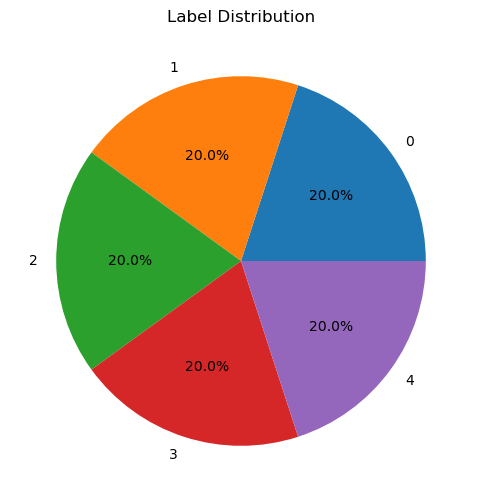

In [6]:
# Count the occurrences of each label
label_counts = train_df['label'].value_counts().sort_index()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Label Distribution')
plt.show()


### Balanced Dataset

## Keep only reviews of length equal to the middle 50%
Assume model will poorly predict sentiment on short reviews and also poorly predict sentiment on long reviews due to truncation

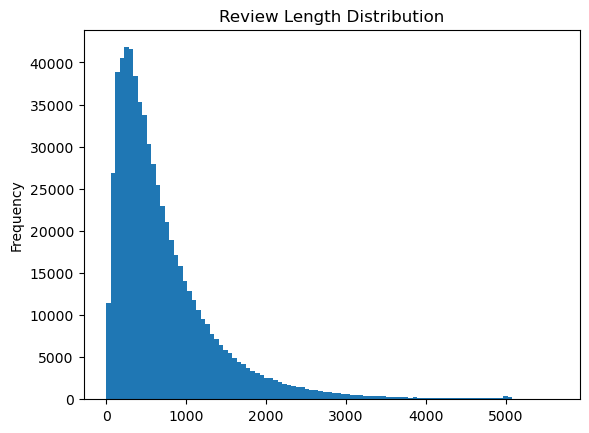

Data shape before filtering:  (650000, 3)


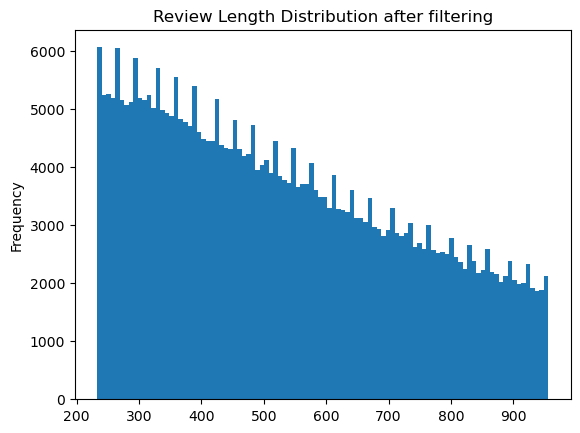

Data shape after filtering:  (365111, 3)


In [7]:
train_df['review_length'] = train_df['text'].apply(len)
train_df['review_length'].plot(kind='hist', bins=100, title='Review Length Distribution')
plt.show()
print('Data shape before filtering: ',train_df.shape)

train_df = train_df[train_df['review_length'] < train_df['review_length'].quantile(0.75)]
train_df = train_df[train_df['review_length'] > train_df['review_length'].quantile(0.25)]
train_df['review_length'].plot(kind='hist', bins=100, title='Review Length Distribution after filtering')
plt.show()
print('Data shape after filtering: ',train_df.shape)

## Defining Sentiment Mapping
* How should we think about review labels and predicted sentiment?
* Obviously, if we only look at 0's and 4's, we expect our model to be more accurate
* What should we consider as neutral?
* What should we consider as positive and negative?
* This choices impact the assessment of the model


This allows us to assess with multiple perspectives

In [8]:
# sentiment_mapping_one = {0: 'negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'positive'} #consider 0=1 negative, 3=4 positive, 2=neutral
# sentiment_mapping_two = {0: 'negative', 1: 'negative', 3: 'positive', 4: 'positive'}  #drop neutral
# sentiment_mapping_three = {0: 'negative', 4: 'positive'} #only look at extremes
# sentiment_mapping_four = {0: 'negative', 1 : 'neutral', 2 : 'neutral', 3: 'neutral', 4: 'positive'} #consider 0 negative, 4 positive, rest neutral

# sentiment_mappings = [sentiment_mapping_one, sentiment_mapping_two, sentiment_mapping_three, sentiment_mapping_four]


## Take subsample of dataset for testing purposes

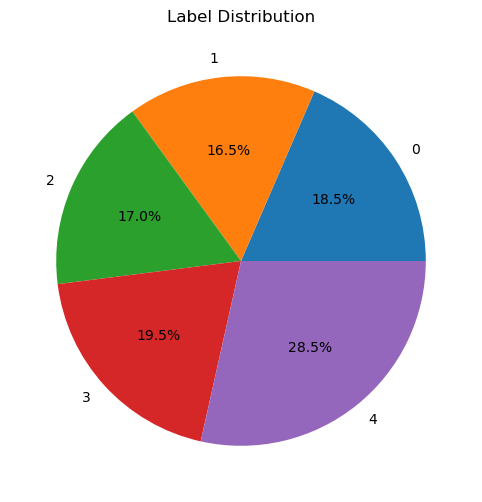

In [9]:
if testing:
    train_df = train_df.sample(sample_size, random_state=42)

    # Count the occurrences of each label
    label_counts = train_df['label'].value_counts().sort_index()

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
    plt.title('Label Distribution')
    plt.show()

## Part 2 - Sentiment Analysis

In [10]:
reviews = train_df['text'].tolist()
all_model_results = [] #store all model results in this list
# sa_folder = 'sentiment_analysis/'
sent_pipes = []
models = []

### Model 1 - https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [11]:
model_one = 'cardiffnlp_twitter-roberta-base-sentiment'
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True, max_length=512)
sent_pipes.append(pipe)
#pipe.__dict__

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
#pipe('test text is this bad or good?')

In [13]:
train_df = create_sent_analysis_or_load(train_df, model_one, pipe, reviews)

# if os.path.exists(model_one + ".csv"):
#     train_df = pd.read_csv(model_one + ".csv")
# else:
#     predictions = pipe(reviews)

#     pred_labels = [pred['label'] for pred in predictions]
#     train_df['pred_label'] = pred_labels

#     pred_probs = [pred['score'] for pred in predictions]
#     train_df['pred_prob'] = pred_probs
    
#     train_df.to_csv(model_one + ".csv")

In [14]:
report_worst_predictions(train_df, 'pred_label', 'label', 'pred_prob', model_one)

	False Positives saved to file cardiffnlp_twitter-roberta-base-sentiment_worst_fp.csv in sentiment_analysis/
	2 0's predicted as positive. Top 10 worst predictions, sorted by probability:

Index 66588: This is a review of the male dance review\nA girlfriend and I went to this club on a Sunday night. The strippers were mostly amatuers and they all danced like girls. We called Palomino and they picked us up from OG and we ended up having a great night!! But you know different strokes for different folks!! I'll pass on OG.
Probability: 0.7783764600753784
-----------------
Index 602950: If you would like to spend $30 on a glorified entree that is the size of a decent appetizer, this is the place for you! If you like to wait 12 minutes for a glass of water when there are only 5 tables filled in the restaurant, this is the place for you! If you like food with no seasoning and tables with salt but no pepper, this is the place for you! If you like to wait 15 minutes for your raw oyster appetiz

## Looks like model struggles with longer reviews

## Use different sentiment mappings to look at confusion matrix 

**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (2, 'neutral'), (3, 'positive'), (4, 'positive')]
Number of predictions: 200


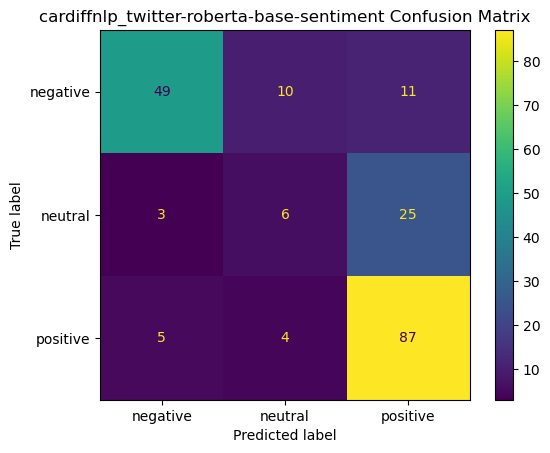

              precision    recall  f1-score   support

    negative       0.86      0.70      0.77        70
     neutral       0.30      0.18      0.22        34
    positive       0.71      0.91      0.79        96

    accuracy                           0.71       200
   macro avg       0.62      0.59      0.60       200
weighted avg       0.69      0.71      0.69       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


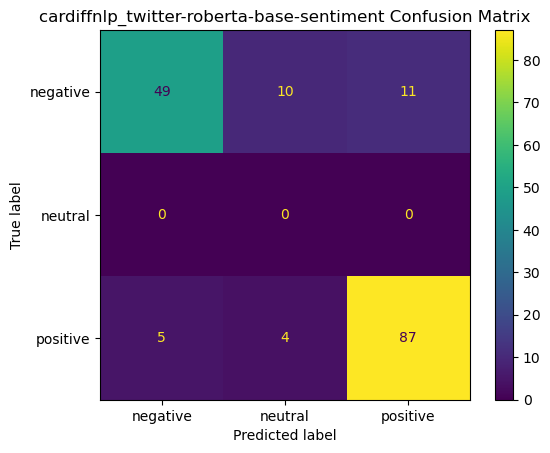

              precision    recall  f1-score   support

    negative       0.91      0.70      0.79        70
     neutral       0.00      0.00      0.00         0
    positive       0.89      0.91      0.90        96

    accuracy                           0.82       166
   macro avg       0.60      0.54      0.56       166
weighted avg       0.90      0.82      0.85       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


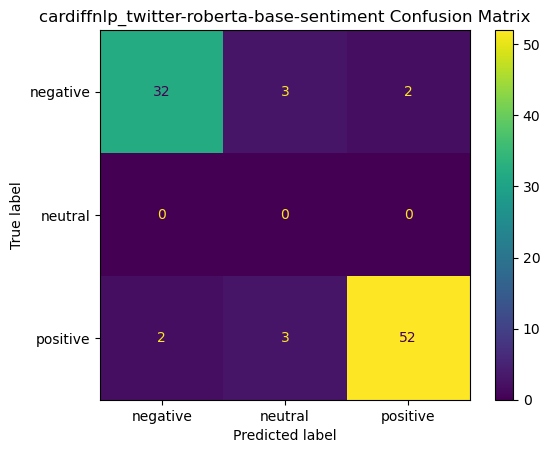

              precision    recall  f1-score   support

    negative       0.94      0.86      0.90        37
     neutral       0.00      0.00      0.00         0
    positive       0.96      0.91      0.94        57

    accuracy                           0.89        94
   macro avg       0.63      0.59      0.61        94
weighted avg       0.95      0.89      0.92        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


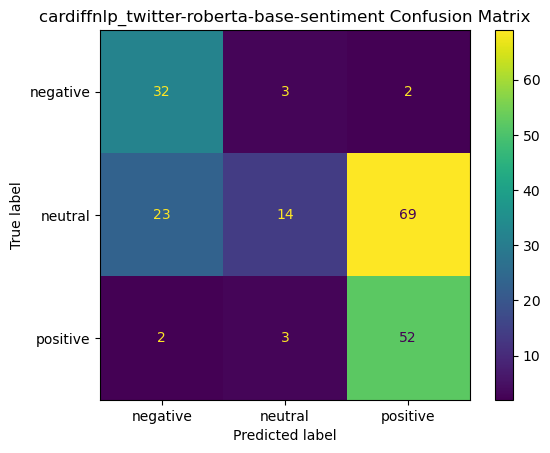

              precision    recall  f1-score   support

    negative       0.56      0.86      0.68        37
     neutral       0.70      0.13      0.22       106
    positive       0.42      0.91      0.58        57

    accuracy                           0.49       200
   macro avg       0.56      0.64      0.49       200
weighted avg       0.60      0.49      0.41       200

**********************************************************************************


In [15]:
# model_assessment = {}
# model_assessment['model'] = model_one

# for i, sentinment_map in enumerate(sentiment_mappings):
#     model_assessment['mapping_'+str(i)+'_accuracy'] = plot_confusion_matrix(train_df, 'pred_label', 'label', sentinment_map, model_one)
#     print('**********************************************************************************')

model_assessment = conf_matrix_all_sent_maps_per_model(train_df, model_one, sentiment_mappings)
all_model_results.append(model_assessment)

## Model 2

https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english


This model doesn't have a neutral output

In [16]:
model_two = 'distilbert-base-uncased-finetuned-sst-2-english'

pipe = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #when do i have to do this?

sent_pipes.append(pipe)
#pipe.__dict__

In [17]:
pipe('test text is this bad or good?')

[{'label': 'NEGATIVE', 'score': 0.9996015429496765}]

In [18]:
train_df = create_sent_analysis_or_load(train_df, model_two, pipe, reviews)

In [19]:
report_worst_predictions(train_df, 'pred_label', 'label', 'pred_prob', model_two)

	False Positives saved to file distilbert-base-uncased-finetuned-sst-2-english_worst_fp.csv in sentiment_analysis/
	2 0's predicted as positive. Top 10 worst predictions, sorted by probability:

Index 66588: This is a review of the male dance review\nA girlfriend and I went to this club on a Sunday night. The strippers were mostly amatuers and they all danced like girls. We called Palomino and they picked us up from OG and we ended up having a great night!! But you know different strokes for different folks!! I'll pass on OG.
Probability: 0.9985981583595276
-----------------
Index 602950: If you would like to spend $30 on a glorified entree that is the size of a decent appetizer, this is the place for you! If you like to wait 12 minutes for a glass of water when there are only 5 tables filled in the restaurant, this is the place for you! If you like food with no seasoning and tables with salt but no pepper, this is the place for you! If you like to wait 15 minutes for your raw oyster a

**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (2, 'neutral'), (3, 'positive'), (4, 'positive')]
Number of predictions: 200


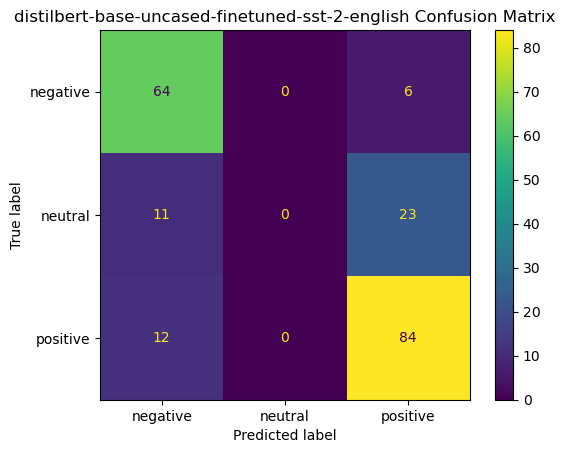

              precision    recall  f1-score   support

    negative       0.74      0.91      0.82        70
     neutral       0.00      0.00      0.00        34
    positive       0.74      0.88      0.80        96

    accuracy                           0.74       200
   macro avg       0.49      0.60      0.54       200
weighted avg       0.61      0.74      0.67       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


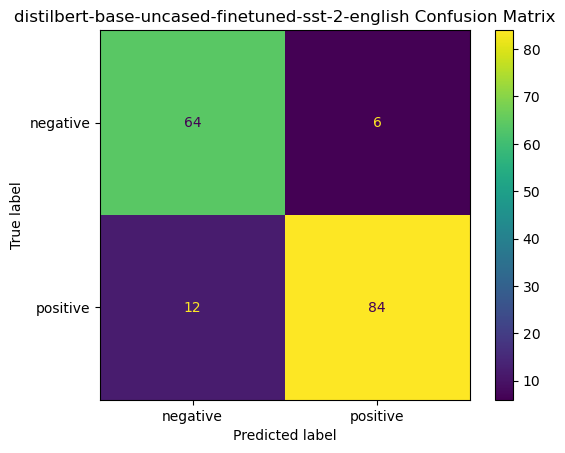

              precision    recall  f1-score   support

    negative       0.84      0.91      0.88        70
    positive       0.93      0.88      0.90        96

    accuracy                           0.89       166
   macro avg       0.89      0.89      0.89       166
weighted avg       0.89      0.89      0.89       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


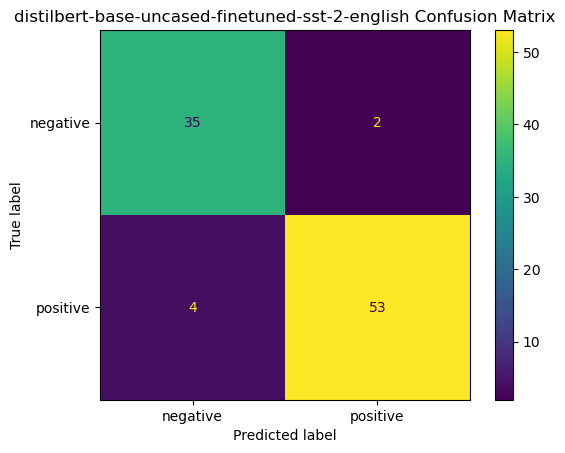

              precision    recall  f1-score   support

    negative       0.90      0.95      0.92        37
    positive       0.96      0.93      0.95        57

    accuracy                           0.94        94
   macro avg       0.93      0.94      0.93        94
weighted avg       0.94      0.94      0.94        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


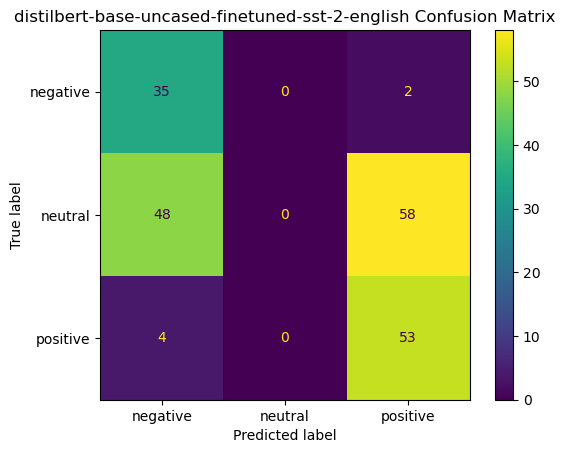

              precision    recall  f1-score   support

    negative       0.40      0.95      0.56        37
     neutral       0.00      0.00      0.00       106
    positive       0.47      0.93      0.62        57

    accuracy                           0.44       200
   macro avg       0.29      0.63      0.40       200
weighted avg       0.21      0.44      0.28       200

**********************************************************************************


In [20]:
model_assessment = conf_matrix_all_sent_maps_per_model(train_df, model_two, sentiment_mappings)
all_model_results.append(model_assessment)

## Model 3

https://huggingface.co/siebert/sentiment-roberta-large-english




In [21]:
model_three = 'siebert_sentiment-roberta-large-english'

pipe = pipeline("text-classification", model="siebert/sentiment-roberta-large-english")

sent_pipes.append(pipe)
#pipe.__dict__

In [22]:
pipe('test text is this bad or good?')

[{'label': 'NEGATIVE', 'score': 0.996304988861084}]

In [23]:
train_df = create_sent_analysis_or_load(train_df, model_three, pipe, reviews)

In [24]:
report_worst_predictions(train_df, 'pred_label', 'label', 'pred_prob', model_three)

	False Positives saved to file siebert_sentiment-roberta-large-english_worst_fp.csv in sentiment_analysis/
	0 0's predicted as positive. Top 10 worst predictions, sorted by probability:

*****************************************************************************************
	False Negatives saved to file siebert_sentiment-roberta-large-english_worst_fn.csv in sentiment_analysis/
	1 4's predicted as negative. Top 10 worst predictions, sorted by probability:

Index 324287: go see this zoo.  it's not the best zoo around, ok maybe it's the worst zoo around, BUT, it has some interesting animals and they clearly need your entrance fee to support their non-profit-ness.   Use the coupon on their web page to get a few bucks off. (it's not that much to get in to begin with)  then Toss them $5 or $10 toward getting a new alligator pond.  they need one bad. and a benefit.  Bebe N. is so right. they need a benefit.  I'll come and invite friends who love animals and tell them to bring lots of cash

**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (2, 'neutral'), (3, 'positive'), (4, 'positive')]
Number of predictions: 200


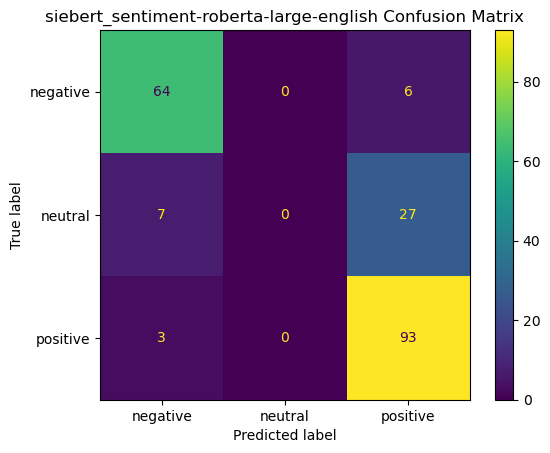

              precision    recall  f1-score   support

    negative       0.86      0.91      0.89        70
     neutral       0.00      0.00      0.00        34
    positive       0.74      0.97      0.84        96

    accuracy                           0.79       200
   macro avg       0.53      0.63      0.58       200
weighted avg       0.66      0.79      0.71       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


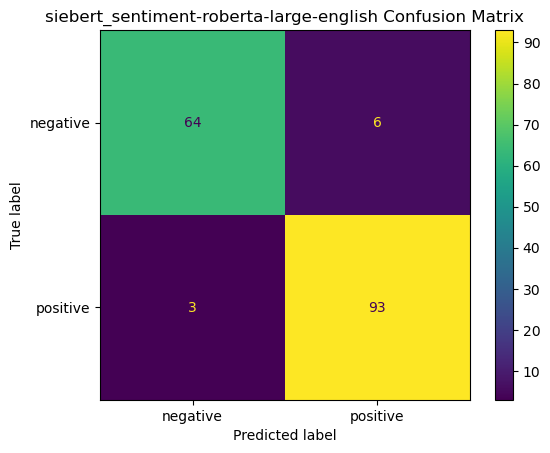

              precision    recall  f1-score   support

    negative       0.96      0.91      0.93        70
    positive       0.94      0.97      0.95        96

    accuracy                           0.95       166
   macro avg       0.95      0.94      0.94       166
weighted avg       0.95      0.95      0.95       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


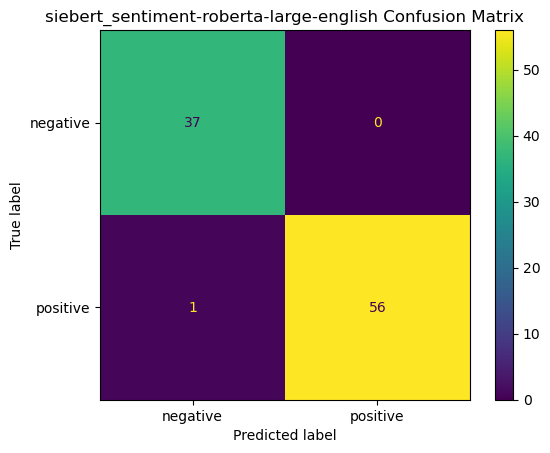

              precision    recall  f1-score   support

    negative       0.97      1.00      0.99        37
    positive       1.00      0.98      0.99        57

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


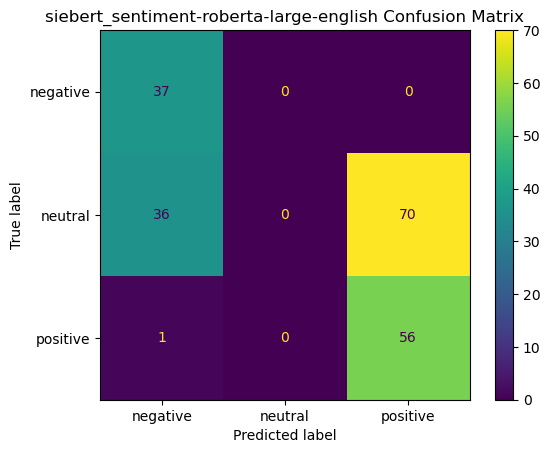

              precision    recall  f1-score   support

    negative       0.50      1.00      0.67        37
     neutral       0.00      0.00      0.00       106
    positive       0.44      0.98      0.61        57

    accuracy                           0.47       200
   macro avg       0.31      0.66      0.43       200
weighted avg       0.22      0.47      0.30       200

**********************************************************************************


In [25]:
model_assessment = conf_matrix_all_sent_maps_per_model(train_df, model_three, sentiment_mappings)
all_model_results.append(model_assessment)

In [ ]:
model_one = 'cardiffnlp_twitter-roberta-base-sentiment'
models.append(model_one)
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True, max_length=512)
sent_pipes.append(pipe)

model_two = 'distilbert-base-uncased-finetuned-sst-2-english'
models.append(model_two)
pipe = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #when do i have to do this?
sent_pipes.append(pipe)

model_three = 'siebert_sentiment-roberta-large-english'
models.append(model_three)
pipe = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", truncation=True, max_length=512)
sent_pipes.append(pipe)

In [ ]:
all_sent_model_acc_score = []
for model_name, pipe in zip(models, sent_pipe):
    sent_analyzed_train_df = create_sent_analysis_or_load(train_df, model_name, pipe, reviews)
    train_df[model_name + '_pred_label'] = sent_analyzed_train_df['pred_label']

    report_worst_predictions(sent_analyzed_train_df, 'pred_label', 'label', 'pred_prob', model_name)

    model_acc_scores = conf_matrix_all_sent_maps_per_model(sent_analyzed_train_df, model_name, sentiment_mappings)
    all_sent_model_acc_score.append(model_acc_scores)


## Compare Models

In [26]:
pprint(all_sent_model_acc_score)

[{'mapping_0_accuracy': 0.71,
  'mapping_1_accuracy': 0.8193,
  'mapping_2_accuracy': 0.8936,
  'mapping_3_accuracy': 0.49,
  'model_name': 'cardiffnlp_twitter-roberta-base-sentiment'},
 {'mapping_0_accuracy': 0.74,
  'mapping_1_accuracy': 0.8916,
  'mapping_2_accuracy': 0.9362,
  'mapping_3_accuracy': 0.44,
  'model_name': 'distilbert-base-uncased-finetuned-sst-2-english'},
 {'mapping_0_accuracy': 0.785,
  'mapping_1_accuracy': 0.9458,
  'mapping_2_accuracy': 0.9894,
  'mapping_3_accuracy': 0.465,
  'model_name': 'siebert_sentiment-roberta-large-english'}]


['sentiment label mapping',
 {0: 'negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'positive'},
 {0: 'negative', 1: 'negative', 3: 'positive', 4: 'positive'},
 {0: 'negative', 4: 'positive'},
 {0: 'negative', 1: 'neutral', 2: 'neutral', 3: 'neutral', 4: 'positive'}]

In [90]:
all_sent_model_acc_score = all_model_results
mapping_dict = {}
y = sentiment_mappings
y.insert(0, 'sentiment label mapping')
for key, map in zip(all_sent_model_acc_score[0].keys(), y):
    mapping_dict[key] = map 
all_sent_model_acc_score.append(mapping_dict)
acc_comparisom = pd.DataFrame(all_sent_model_acc_score)

,model_name,mapping_0_accuracy,mapping_1_accuracy,mapping_2_accuracy,mapping_3_accuracy
0,cardiffnlp_twitter-roberta-base-sentiment,0.71,0.8193,0.8936,0.49
1,distilbert-base-uncased-finetuned-sst-2-english,0.74,0.8916,0.9362,0.44
2,siebert_sentiment-roberta-large-english,0.785,0.9458,0.9894,0.465
3,"{0: 'negative', 1: 'negative', 2: 'neutral', 3...","{0: 'negative', 1: 'negative', 3: 'positive', ...","{0: 'negative', 4: 'positive'}","{0: 'negative', 1: 'neutral', 2: 'neutral', 3:...",NaN
4,sentiment label mapping,"{0: 'negative', 1: 'negative', 2: 'neutral', 3...","{0: 'negative', 1: 'negative', 3: 'positive', ...","{0: 'negative', 4: 'positive'}","{0: 'negative', 1: 'neutral', 2: 'neutral', 3:..."


In [27]:
for i in
acc_comparison = pd.DataFrame(all_sent_model_acc_score)
acc_comparison.to_csv(sa_folder+'sentiment_model_accuracy_comparison.csv')

acc_comparison

,model_name,mapping_0_accuracy,mapping_1_accuracy,mapping_2_accuracy,mapping_3_accuracy
0,cardiffnlp_twitter-roberta-base-sentiment,0.710,0.8193,0.8936,0.490
1,distilbert-base-uncased-finetuned-sst-2-english,0.740,0.8916,0.9362,0.440
2,siebert_sentiment-roberta-large-english,0.785,0.9458,0.9894,0.465


In [28]:
c=0
for mapping in sentiment_mappings:
    print(f'Mapping_{c}:  {list(mapping.items())}')
    c+=1
    

Mapping_0:  [(0, 'negative'), (1, 'negative'), (2, 'neutral'), (3, 'positive'), (4, 'positive')]
Mapping_1:  [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Mapping_2:  [(0, 'negative'), (4, 'positive')]
Mapping_3:  [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]


##  model 3, Sibert/sentiment-roberta-large-english is the clear winner across all mappings except for the last, but that mapping is not a good one to judge by

In [29]:
models = [model_one, model_two, model_three]

model_compare = train_df[['text', 'label']]

for model in models:
    model_df = pd.read_csv(sa_folder+model + "_sent_analysis.csv", index_col = 0)
    model_compare[model + '_pred_label'] = model_df['pred_label'].str.lower()

model_compare.to_csv(sa_folder+'model_comparison.csv')

model_compare

C:\Users\domin\AppData\Local\Temp\ipykernel_33912\2355736235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_compare[model + '_pred_label'] = model_df['pred_label'].str.lower()


,text,label,cardiffnlp_twitter-roberta-base-sentiment_pred_label,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label
352956,This place is brilliant. For a night out defi...,4,positive,positive,positive
34248,Ok I'll admit they have reasonable prices on s...,2,positive,negative,positive
555818,I've wanted to come to Crudo for awhile so I w...,2,positive,positive,positive
403173,Good flavorful food but personally I didn't li...,1,negative,negative,negative
263526,If I could give this place no stars I would!!!...,0,negative,negative,negative
...,...,...,...,...,...
633095,They may have renovated the outside... They ma...,1,negative,negative,negative
5422,Stopped by here for an early lunch. The place ...,4,positive,positive,positive
62931,I have been a five to six time a year customer...,2,neutral,positive,negative
545733,Great little sandwich shop! They have a variet...,4,positive,positive,positive


## Find disagreements

In [30]:
disagreements = model_compare[model_compare[[model + '_pred_label' for model in models]].nunique(axis=1) > 1]
disagreements.to_csv(sa_folder+'sentiment_model_disagreements.csv')

In [31]:
disagreements

,text,label,cardiffnlp_twitter-roberta-base-sentiment_pred_label,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label
34248,Ok I'll admit they have reasonable prices on s...,2,positive,negative,positive
326802,I've only been here a couple of times with som...,3,positive,negative,positive
602950,If you would like to spend $30 on a glorified ...,0,positive,positive,negative
13871,I came here after a grueling evening swim prac...,1,positive,negative,negative
264667,"Here is what I can tell you about The Mix, it ...",1,positive,negative,negative
141516,If you have the power to write what every you ...,1,neutral,negative,negative
270066,It's a very nice Hotel and the Staff is very f...,1,positive,negative,negative
227086,"With a friend and I craving sushi, and being i...",1,neutral,negative,positive
72017,My review is for the casino only. It is clean...,1,negative,positive,negative
352535,My coworker and I kept noticing the long lines...,1,positive,negative,negative


### Look at distribution of disagreements

In [32]:
disagreements['label'].value_counts()

label
1    16
2    12
3    11
4     6
0     5
Name: count, dtype: int64

In [33]:
incorrect_negatives = disagreements[disagreements['label'] == 0]
max_negatives = incorrect_negatives.shape[0]
report_num = min(10, max_negatives)
for i in range(report_num):
    print(f"Review: {incorrect_negatives.iloc[i]['text']}")
    print(f"True label: {incorrect_negatives.iloc[i]['label']}")
    for model in models:
        print(f"{model} prediction: {incorrect_negatives.iloc[i][model + '_pred_label']}")
    print('-----------------')
    print('-----------------')

Review: If you would like to spend $30 on a glorified entree that is the size of a decent appetizer, this is the place for you! If you like to wait 12 minutes for a glass of water when there are only 5 tables filled in the restaurant, this is the place for you! If you like food with no seasoning and tables with salt but no pepper, this is the place for you! If you like to wait 15 minutes for your raw oyster appetizer (after the 12 minute water wait), this is the place for you! If you like to waste your time, money, and have these to burn, this is the place for You!!!!!!
True label: 0
cardiffnlp_twitter-roberta-base-sentiment prediction: positive
distilbert-base-uncased-finetuned-sst-2-english prediction: positive
siebert_sentiment-roberta-large-english prediction: negative
-----------------
-----------------
Review: I will preface this by saying that I do understand that Burger King is considered fast food, but I was heading through the LV airport on the way home and decided to grab a 

In [34]:
incorrect_positives = disagreements[disagreements['label'] == 4]
max_positives = incorrect_positives.shape[0]
report_num = min(10, max_positives)
for i in range(report_num):
    print(f"Review: {incorrect_positives.iloc[i]['text']}")
    print(f"True label: {incorrect_positives.iloc[i]['label']}")
    for model in models:
        print(f"{model} prediction: {incorrect_positives.iloc[i][model + '_pred_label']}")
    print('-----------------')
    print('-----------------')

Review: Similaire \u00e0 mon amour pour le Vieux-Port, ce coin de la ville repr\u00e9sente pour moi un vestige de l'\u00e8re industrielle, de l'industrie du textile d'antan et des premiers brasseurs d'ici! Bref, un canal o\u00f9 on part \u00e0 la rencontre, en kayak, \u00e0 v\u00e9lo, \u00e0 pied ou en roller, d'un pass\u00e9 important et marquant de notre ville. \n\nCe que j'adore, ici, c'est l'enthousiasme des gens locaux qui fr\u00e9quentent quotidiennement ses sentiers, qui longent son cours d'eau et qui savent \u00e0 quel point le parc \u00e0 chang\u00e9 depuis les 10 derni\u00e8res ann\u00e9es. \n\nC'est un superbe endroit pour faire du sport, un pique-nique, se retrouver seul pour penser ou pour partir \u00e0 la d\u00e9couverte de parties int\u00e9grales de l'histoire d'une ville! \n\nBonnes d\u00e9couvertes!
True label: 4
cardiffnlp_twitter-roberta-base-sentiment prediction: neutral
distilbert-base-uncased-finetuned-sst-2-english prediction: negative
siebert_sentiment-roberta-l

In [35]:
worst_predictions = pd.concat([incorrect_negatives, incorrect_positives])
worst_predictions['sentiment'] = worst_predictions['label'].map(sentiment_mapping_three)
worst_predictions

model_failures = {}
for model in models:
    worst_predictions[model+'_failure'] = worst_predictions[model + '_pred_label'] != worst_predictions['sentiment']
    model_failures[model] = worst_predictions[model+'_failure'].sum()

worst_predictions

,text,label,cardiffnlp_twitter-roberta-base-sentiment_pred_label,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label,sentiment,cardiffnlp_twitter-roberta-base-sentiment_failure,distilbert-base-uncased-finetuned-sst-2-english_failure,siebert_sentiment-roberta-large-english_failure
602950,If you would like to spend $30 on a glorified ...,0,positive,positive,negative,negative,True,True,False
571745,I will preface this by saying that I do unders...,0,neutral,negative,negative,negative,True,False,False
485502,I needed three appliances repaired so I though...,0,neutral,negative,negative,negative,True,False,False
605286,I went here today after all the rave reviews a...,0,neutral,negative,negative,negative,True,False,False
66588,This is a review of the male dance review\nA g...,0,positive,positive,negative,negative,True,True,False
488888,"Similaire \u00e0 mon amour pour le Vieux-Port,...",4,neutral,negative,positive,positive,True,True,False
324287,go see this zoo. it's not the best zoo around...,4,positive,negative,negative,positive,False,True,True
346054,Peu m'importe que le march\u00e9 soit loin de ...,4,neutral,negative,positive,positive,True,True,False
511146,"Call me premenstrual or just sensitive, but to...",4,negative,negative,positive,positive,True,True,False
332869,"First time reviewer of anything, but I do cons...",4,neutral,positive,positive,positive,True,False,False


In [36]:
pd.Series(model_failures)

cardiffnlp_twitter-roberta-base-sentiment          10
distilbert-base-uncased-finetuned-sst-2-english     6
siebert_sentiment-roberta-large-english             1
dtype: int64

Siebert is a winner

# Part 3 - Zero Shot Classification

In [37]:
train_df = train_df.drop(columns=['pred_label', 'pred_prob'])
train_df

,label,text
352956,4,This place is brilliant. For a night out defi...
34248,2,Ok I'll admit they have reasonable prices on s...
555818,2,I've wanted to come to Crudo for awhile so I w...
403173,1,Good flavorful food but personally I didn't li...
263526,0,If I could give this place no stars I would!!!...
...,...,...
633095,1,They may have renovated the outside... They ma...
5422,4,Stopped by here for an early lunch. The place ...
62931,2,I have been a five to six time a year customer...
545733,4,Great little sandwich shop! They have a variet...


## Summarization

Reviews are already pretty short. The average number of tokens in a review (filtered to include middle 50% by char length from step 1) is on the order of 130. The model we use defaults to summmarizations with a maximum length of 147. 

Set summarization model max_length to about half the number of tokens found in the minumum review. Set min_length to something like 10 tokens.

What should we do?

## We're trying to summarize reviews, which are already pretty short.

In [38]:
model = 'facebook/bart-large-cnn'
sum_folder = 'summary_sentiment_analysis/'

In [39]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

In [40]:
review_token_length = []
for review in reviews:
    tokenized_review = tokenizer(review)
    review_token_length.append(len(tokenized_review['input_ids']))


In [41]:
np.mean(review_token_length)

130.435

In [42]:
np.min(review_token_length)

49

In [43]:
summarizer = pipeline("summarization", model=model, max_length=25, min_length=10)

In [44]:
summarizer(reviews[5])[0]

{'summary_text': 'The food is excellent - the soups are amazing (especially the Garden Chili and Tomato Basil Feta soup)'}

In [45]:
if not os.path.exists(sum_folder):
    os.makedirs(sum_folder)
if not os.path.exists(sum_folder+'summarized_reviews.csv'):
    summaries = [summarizer(review)[0]['summary_text'] for review in reviews]
    train_df['summary'] = summaries
    train_df.to_csv(sum_folder+'summarized_reviews.csv')
else:
    train_df = pd.read_csv(sum_folder+'summarized_reviews.csv', index_col=0)

In [46]:
train_df

,label,text,summary
352956,4,This place is brilliant. For a night out defi...,This place is brilliant. For a night out defin...
34248,2,Ok I'll admit they have reasonable prices on s...,This is a fine place to go shooting as long as...
555818,2,I've wanted to come to Crudo for awhile so I w...,The wait staff was professional and efficient....
403173,1,Good flavorful food but personally I didn't li...,Good flavorful food but personally I didn't li...
263526,0,If I could give this place no stars I would!!!...,The manager didn't even check in his stock and...
...,...,...,...
633095,1,They may have renovated the outside... They ma...,"Our room on the 12th floor stank of mildew, th..."
5422,4,Stopped by here for an early lunch. The place ...,Alexander Michaels is a new restaurant in Char...
62931,2,I have been a five to six time a year customer...,The Joshephina omelet was overcooked to point ...
545733,4,Great little sandwich shop! They have a variet...,Great little sandwich shop! They have a variet...


# Part 3a

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Running sentiment analysis for cardiffnlp_twitter-roberta-base-sentiment
	False Positives saved to file cardiffnlp_twitter-roberta-base-sentiment_worst_fp.csv in summary_sentiment_analysis/
	4 0's predicted as positive. Top 10 worst predictions, sorted by probability:

Index 596457: Was really looking forward to a burlesque type show.   The music was good and the dancers were entertaining.   Clair St Claire was less then entertaining.  She is the \"star\" of the show and seems very awkward on stage the whole time.   I felt a little bad for her because it really seems like she doesn't even want to be there....and I cant say that I blame her.    The show room was dirty and pretty gross.   The tickets were WAY overpriced for what this show is about.   Unless you get VERY discounted tickets or maybe free ones...I wouldn't waste your money.    Claire St Claire is a

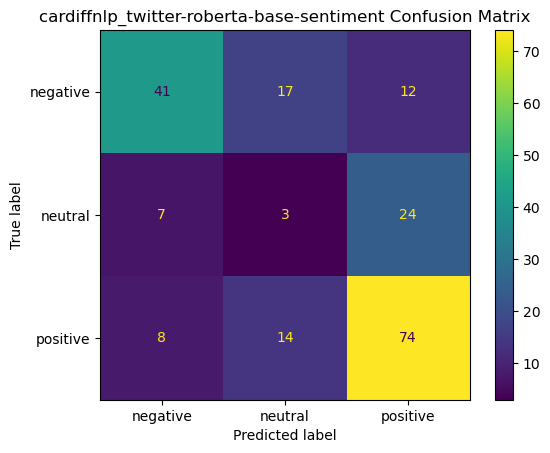

              precision    recall  f1-score   support

    negative       0.73      0.59      0.65        70
     neutral       0.09      0.09      0.09        34
    positive       0.67      0.77      0.72        96

    accuracy                           0.59       200
   macro avg       0.50      0.48      0.49       200
weighted avg       0.59      0.59      0.59       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


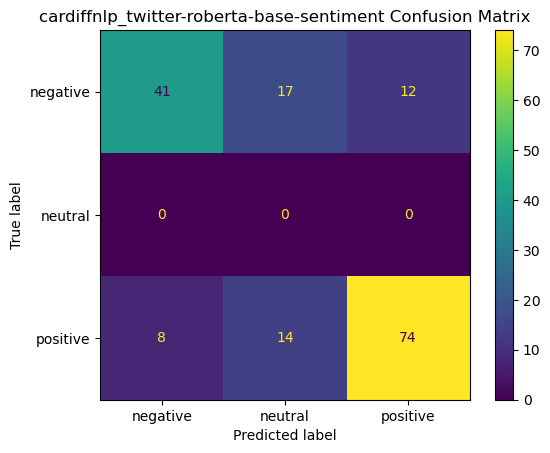

              precision    recall  f1-score   support

    negative       0.84      0.59      0.69        70
     neutral       0.00      0.00      0.00         0
    positive       0.86      0.77      0.81        96

    accuracy                           0.69       166
   macro avg       0.57      0.45      0.50       166
weighted avg       0.85      0.69      0.76       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


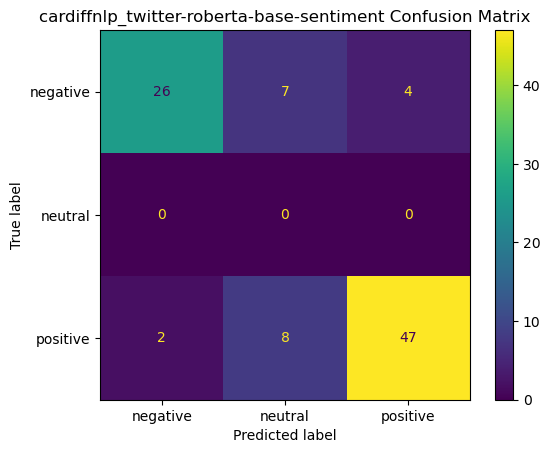

              precision    recall  f1-score   support

    negative       0.93      0.70      0.80        37
     neutral       0.00      0.00      0.00         0
    positive       0.92      0.82      0.87        57

    accuracy                           0.78        94
   macro avg       0.62      0.51      0.56        94
weighted avg       0.92      0.78      0.84        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


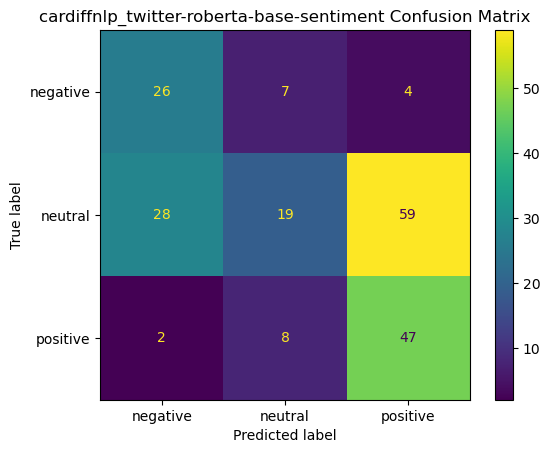

              precision    recall  f1-score   support

    negative       0.46      0.70      0.56        37
     neutral       0.56      0.18      0.27       106
    positive       0.43      0.82      0.56        57

    accuracy                           0.46       200
   macro avg       0.48      0.57      0.46       200
weighted avg       0.50      0.46      0.41       200

**********************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Running sentiment analysis for distilbert-base-uncased-finetuned-sst-2-english
	False Positives saved to file distilbert-base-uncased-finetuned-sst-2-english_worst_fp.csv in summary_sentiment_analysis/
	3 0's predicted as positive. Top 10 worst predictions, sorted by probability:

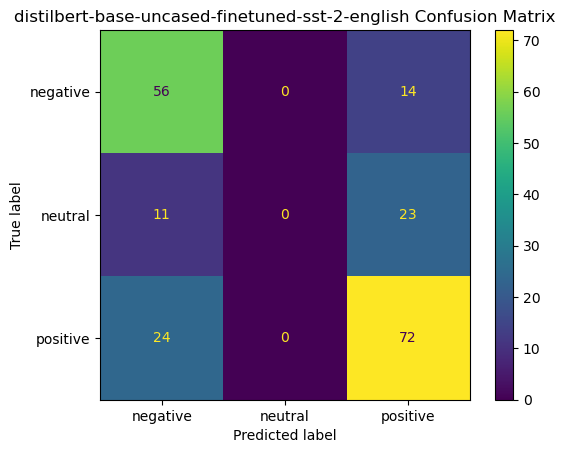

              precision    recall  f1-score   support

    negative       0.62      0.80      0.70        70
     neutral       0.00      0.00      0.00        34
    positive       0.66      0.75      0.70        96

    accuracy                           0.64       200
   macro avg       0.43      0.52      0.47       200
weighted avg       0.53      0.64      0.58       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


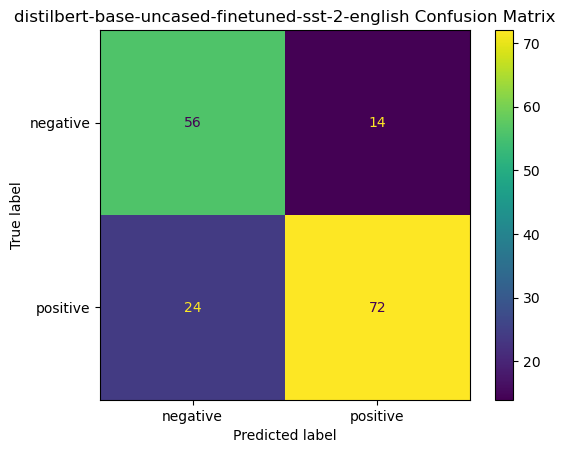

              precision    recall  f1-score   support

    negative       0.70      0.80      0.75        70
    positive       0.84      0.75      0.79        96

    accuracy                           0.77       166
   macro avg       0.77      0.78      0.77       166
weighted avg       0.78      0.77      0.77       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


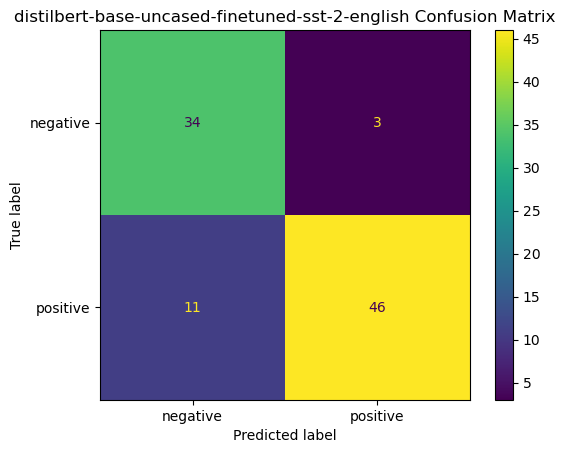

              precision    recall  f1-score   support

    negative       0.76      0.92      0.83        37
    positive       0.94      0.81      0.87        57

    accuracy                           0.85        94
   macro avg       0.85      0.86      0.85        94
weighted avg       0.87      0.85      0.85        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


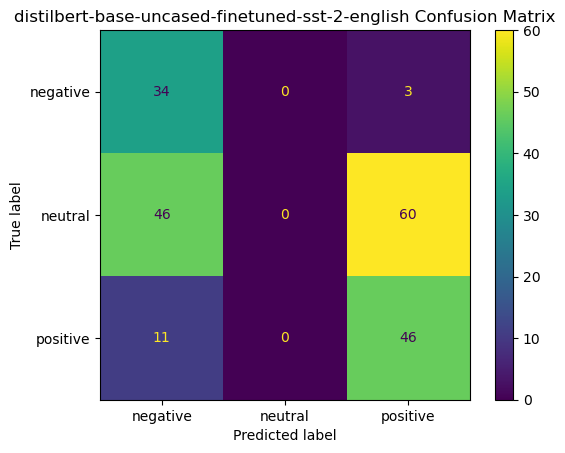

              precision    recall  f1-score   support

    negative       0.37      0.92      0.53        37
     neutral       0.00      0.00      0.00       106
    positive       0.42      0.81      0.55        57

    accuracy                           0.40       200
   macro avg       0.27      0.58      0.36       200
weighted avg       0.19      0.40      0.26       200

**********************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Running sentiment analysis for siebert_sentiment-roberta-large-english
	False Positives saved to file siebert_sentiment-roberta-large-english_worst_fp.csv in summary_sentiment_analysis/
	6 0's predicted as positive. Top 10 worst predictions, sorted by probability:

Index 596457: 

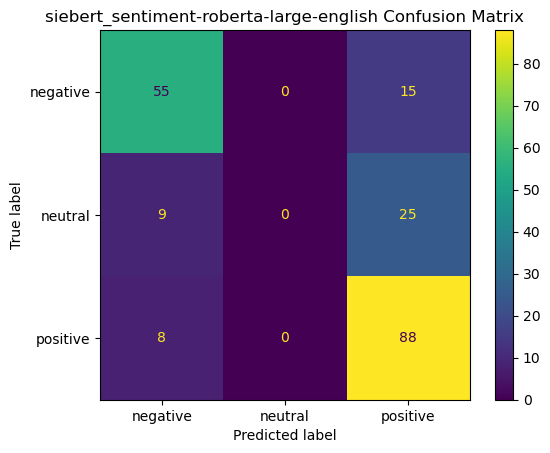

              precision    recall  f1-score   support

    negative       0.76      0.79      0.77        70
     neutral       0.00      0.00      0.00        34
    positive       0.69      0.92      0.79        96

    accuracy                           0.71       200
   macro avg       0.48      0.57      0.52       200
weighted avg       0.60      0.71      0.65       200

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'negative'), (3, 'positive'), (4, 'positive')]
Number of predictions: 166


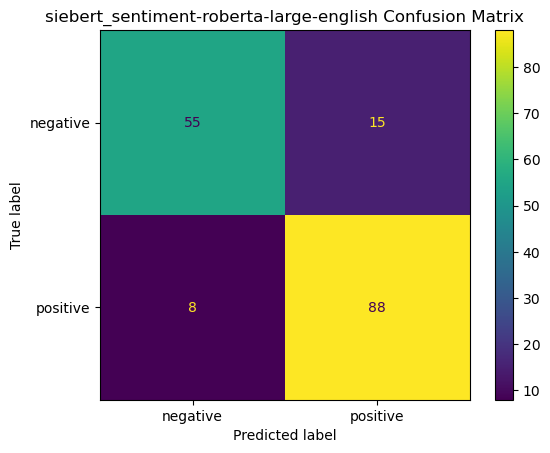

              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        70
    positive       0.85      0.92      0.88        96

    accuracy                           0.86       166
   macro avg       0.86      0.85      0.86       166
weighted avg       0.86      0.86      0.86       166

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (4, 'positive')]
Number of predictions: 94


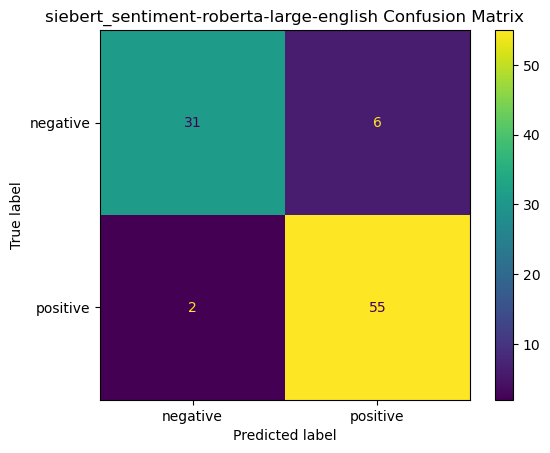

              precision    recall  f1-score   support

    negative       0.94      0.84      0.89        37
    positive       0.90      0.96      0.93        57

    accuracy                           0.91        94
   macro avg       0.92      0.90      0.91        94
weighted avg       0.92      0.91      0.91        94

**********************************************************************************
**********************************************************************************
Mapping from original data to prediction labels: [(0, 'negative'), (1, 'neutral'), (2, 'neutral'), (3, 'neutral'), (4, 'positive')]
Number of predictions: 200


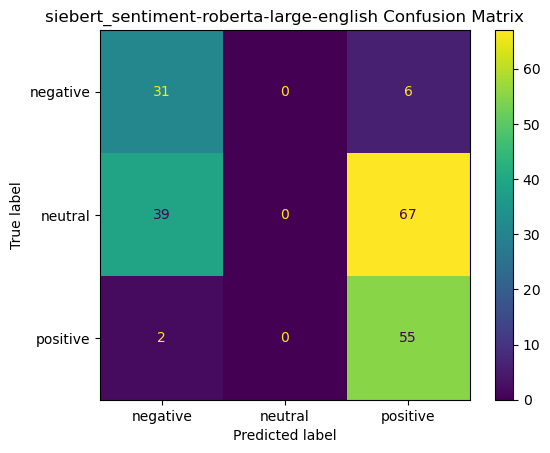

              precision    recall  f1-score   support

    negative       0.43      0.84      0.57        37
     neutral       0.00      0.00      0.00       106
    positive       0.43      0.96      0.59        57

    accuracy                           0.43       200
   macro avg       0.29      0.60      0.39       200
weighted avg       0.20      0.43      0.27       200

**********************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [47]:
all_model_summary_results = []
for model, pipe in zip(models, sent_pipes):

    print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
    print(f'Running sentiment analysis for {model}')
    train_df = create_sent_analysis_or_load(train_df, model, pipe, summaries, pred_col_name = model + '_sum_pred_label', sa_folder = sum_folder, pred_prob_col_name = model + '_sum_pred_prob')
    report_worst_predictions(train_df, model+'_sum_pred_label', 'label', model + '_sum_pred_prob', model, sa_folder = sum_folder, text = 'summary')
    model_assessment = conf_matrix_all_sent_maps_per_model(train_df, model, sentiment_mappings, pred_col_name = model + '_sum_pred_label', true_col_name = 'label')
    all_model_summary_results.append(model_assessment)
    print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')

In [48]:
pprint(all_model_summary_results)

acc_comparison = pd.DataFrame(all_model_summary_results)
acc_comparison.to_csv(sum_folder+'sentiment_model_accuracy_comparison.csv')

acc_comparison

[{'mapping_0_accuracy': 0.59,
  'mapping_1_accuracy': 0.6928,
  'mapping_2_accuracy': 0.7766,
  'mapping_3_accuracy': 0.46,
  'model_name': 'cardiffnlp_twitter-roberta-base-sentiment'},
 {'mapping_0_accuracy': 0.64,
  'mapping_1_accuracy': 0.7711,
  'mapping_2_accuracy': 0.8511,
  'mapping_3_accuracy': 0.4,
  'model_name': 'distilbert-base-uncased-finetuned-sst-2-english'},
 {'mapping_0_accuracy': 0.715,
  'mapping_1_accuracy': 0.8614,
  'mapping_2_accuracy': 0.9149,
  'mapping_3_accuracy': 0.43,
  'model_name': 'siebert_sentiment-roberta-large-english'}]


,model_name,mapping_0_accuracy,mapping_1_accuracy,mapping_2_accuracy,mapping_3_accuracy
0,cardiffnlp_twitter-roberta-base-sentiment,0.590,0.6928,0.7766,0.46
1,distilbert-base-uncased-finetuned-sst-2-english,0.640,0.7711,0.8511,0.40
2,siebert_sentiment-roberta-large-english,0.715,0.8614,0.9149,0.43


# Part 3b

In [50]:
classes = ['Restaurant', 'Bar', 'Coffee', 'Hotel', 'Salon', 'Automotive', 'Home', 'Medical', 'Entertainment', 'Pet', 'Financial', 'Education', 'Real Estate', 'Fitness', 'Landscaping', 'Legal', 'Travel', 'Event', 'Retail', 'Beauty']
len(classes)

20

In [51]:
model_one = 'facebook-bart-large-mnli'
pipe_one = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

pipe_one(reviews[0], classes)

{'sequence': "This place is brilliant.  For a night out definitely come here first.\\n\\nI tend to buy a couple of pitchers, highly recommend the fruit salad one and the Fab Ice Lolly one. Its just something totally different and a pitcher to 2 people is enough to get you a little tipsy. \\n\\nPrices are a little expensive as pitchers start at \\u00a318 but definitely worth it.\\n\\nShots are around \\u00a33 but who could say no to a bubblegum or birthday cake flavored shot!!! \\n\\nExpensive but enjoyable. I'm pretty sure their food isn't so great however. I vaguely remember inquiring and they told me it was frozen, microwave food. I have not tried it though so no comment as of yet.",
 'labels': ['Entertainment',
  'Bar',
  'Restaurant',
  'Travel',
  'Financial',
  'Event',
  'Retail',
  'Home',
  'Beauty',
  'Hotel',
  'Education',
  'Real Estate',
  'Legal',
  'Salon',
  'Automotive',
  'Fitness',
  'Pet',
  'Medical',
  'Landscaping',
  'Coffee'],
 'scores': [0.25318923592567444,


In [63]:
model_two = 'MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli'
pipe_two = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
pipe_two(reviews[0], classes)


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

c:\Users\domin\anaconda3\envs\transformers_env\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\domin\.cache\huggingface\hub\models--MoritzLaurer--DeBERTa-v3-base-mnli-fever-anli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': "This place is brilliant.  For a night out definitely come here first.\\n\\nI tend to buy a couple of pitchers, highly recommend the fruit salad one and the Fab Ice Lolly one. Its just something totally different and a pitcher to 2 people is enough to get you a little tipsy. \\n\\nPrices are a little expensive as pitchers start at \\u00a318 but definitely worth it.\\n\\nShots are around \\u00a33 but who could say no to a bubblegum or birthday cake flavored shot!!! \\n\\nExpensive but enjoyable. I'm pretty sure their food isn't so great however. I vaguely remember inquiring and they told me it was frozen, microwave food. I have not tried it though so no comment as of yet.",
 'labels': ['Entertainment',
  'Restaurant',
  'Retail',
  'Travel',
  'Financial',
  'Education',
  'Hotel',
  'Legal',
  'Event',
  'Bar',
  'Beauty',
  'Salon',
  'Automotive',
  'Home',
  'Pet',
  'Medical',
  'Real Estate',
  'Landscaping',
  'Fitness',
  'Coffee'],
 'scores': [0.2680423855781555,
 

In [65]:
model_three = 'knowledgator-comprehend_it-base' 
pipe_three = pipeline("zero-shot-classification", model="knowledgator/comprehend_it-base")
pipe_three(reviews[0], classes)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

c:\Users\domin\anaconda3\envs\transformers_env\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\domin\.cache\huggingface\hub\models--knowledgator--comprehend_it-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

{'sequence': "This place is brilliant.  For a night out definitely come here first.\\n\\nI tend to buy a couple of pitchers, highly recommend the fruit salad one and the Fab Ice Lolly one. Its just something totally different and a pitcher to 2 people is enough to get you a little tipsy. \\n\\nPrices are a little expensive as pitchers start at \\u00a318 but definitely worth it.\\n\\nShots are around \\u00a33 but who could say no to a bubblegum or birthday cake flavored shot!!! \\n\\nExpensive but enjoyable. I'm pretty sure their food isn't so great however. I vaguely remember inquiring and they told me it was frozen, microwave food. I have not tried it though so no comment as of yet.",
 'labels': ['Restaurant',
  'Entertainment',
  'Bar',
  'Retail',
  'Event',
  'Beauty',
  'Coffee',
  'Pet',
  'Travel',
  'Legal',
  'Home',
  'Financial',
  'Automotive',
  'Hotel',
  'Real Estate',
  'Fitness',
  'Medical',
  'Education',
  'Salon',
  'Landscaping'],
 'scores': [0.32537841796875,
  0

In [69]:
models = [model_one, model_two, model_three]
pipes = [pipe_one, pipe_two, pipe_three]

In [66]:
train_df

,label,text,summary,cardiffnlp_twitter-roberta-base-sentiment_pred_label,pred_prob,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label
352956,4,This place is brilliant. For a night out defi...,This place is brilliant. For a night out defin...,positive,0.998928,positive,positive
34248,2,Ok I'll admit they have reasonable prices on s...,This is a fine place to go shooting as long as...,positive,0.998682,positive,positive
555818,2,I've wanted to come to Crudo for awhile so I w...,The wait staff was professional and efficient....,positive,0.998903,positive,positive
403173,1,Good flavorful food but personally I didn't li...,Good flavorful food but personally I didn't li...,negative,0.999325,negative,negative
263526,0,If I could give this place no stars I would!!!...,The manager didn't even check in his stock and...,negative,0.999508,negative,negative
...,...,...,...,...,...,...,...
633095,1,They may have renovated the outside... They ma...,"Our room on the 12th floor stank of mildew, th...",negative,0.999450,negative,negative
5422,4,Stopped by here for an early lunch. The place ...,Alexander Michaels is a new restaurant in Char...,positive,0.998782,positive,positive
62931,2,I have been a five to six time a year customer...,The Joshephina omelet was overcooked to point ...,negative,0.999495,negative,negative
545733,4,Great little sandwich shop! They have a variet...,Great little sandwich shop! They have a variet...,positive,0.998871,positive,positive


In [76]:
n = 100

reviews_to_cat = train_df.iloc[:n, :].copy()


for model_name, pipe in zip(models, pipes):

    categories = []
    category_scores = []
    print('***********************************************************************************************')
    print(f"Zero-Shot Encoding with {model_name}")
    for review in reviews[:n]:
        result = pipe_one(review, classes)
        categories.append(result['labels'])
        category_scores.append(result['scores'])
        print('.', end='')
    print('')

    top_cats = [cat[0] for cat in categories]
    top_scores = [score[0] for score in category_scores]

    reviews_to_cat[model_name + '_categories'] = categories
    reviews_to_cat[model_name + '_top_category'] = top_cats
    reviews_to_cat[model_name + '_scores'] = category_scores
    reviews_to_cat[model_name + '_top_score'] = top_scores

reviews_to_cat

***********************************************************************************************
Zero-Shot Encoding with facebook-bart-large-mnli
..
***********************************************************************************************
Zero-Shot Encoding with MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli
..
***********************************************************************************************
Zero-Shot Encoding with knowledgator-comprehend_it-base
..


,label,text,summary,cardiffnlp_twitter-roberta-base-sentiment_pred_label,pred_prob,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label,facebook-bart-large-mnli_categories,facebook-bart-large-mnli_top_category,facebook-bart-large-mnli_scores,facebook-bart-large-mnli_top_score,MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli_categories,MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli_top_category,MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli_scores,MoritzLaurer-DeBERTa-v3-base-mnli-fever-anli_top_score,knowledgator-comprehend_it-base_categories,knowledgator-comprehend_it-base_top_category,knowledgator-comprehend_it-base_scores,knowledgator-comprehend_it-base_top_score
352956,4,This place is brilliant. For a night out defi...,This place is brilliant. For a night out defin...,positive,0.998928,positive,positive,"[Entertainment, Bar, Restaurant, Travel, Finan...",Entertainment,"[0.25318923592567444, 0.13311557471752167, 0.0...",0.253189,"[Entertainment, Bar, Restaurant, Travel, Finan...",Entertainment,"[0.25318923592567444, 0.13311557471752167, 0.0...",0.253189,"[Entertainment, Bar, Restaurant, Travel, Finan...",Entertainment,"[0.25318923592567444, 0.13311557471752167, 0.0...",0.253189
34248,2,Ok I'll admit they have reasonable prices on s...,This is a fine place to go shooting as long as...,positive,0.998682,positive,positive,"[Retail, Financial, Entertainment, Bar, Travel...",Retail,"[0.2128022164106369, 0.11205010116100311, 0.08...",0.212802,"[Retail, Financial, Entertainment, Bar, Travel...",Retail,"[0.2128022164106369, 0.11205010116100311, 0.08...",0.212802,"[Retail, Financial, Entertainment, Bar, Travel...",Retail,"[0.2128022164106369, 0.11205010116100311, 0.08...",0.212802


In [67]:
train_df.iloc[:100, :]

,label,text,summary,cardiffnlp_twitter-roberta-base-sentiment_pred_label,pred_prob,distilbert-base-uncased-finetuned-sst-2-english_pred_label,siebert_sentiment-roberta-large-english_pred_label
352956,4,This place is brilliant. For a night out defi...,This place is brilliant. For a night out defin...,positive,0.998928,positive,positive
34248,2,Ok I'll admit they have reasonable prices on s...,This is a fine place to go shooting as long as...,positive,0.998682,positive,positive
555818,2,I've wanted to come to Crudo for awhile so I w...,The wait staff was professional and efficient....,positive,0.998903,positive,positive
403173,1,Good flavorful food but personally I didn't li...,Good flavorful food but personally I didn't li...,negative,0.999325,negative,negative
263526,0,If I could give this place no stars I would!!!...,The manager didn't even check in his stock and...,negative,0.999508,negative,negative
...,...,...,...,...,...,...,...
309601,1,I didn't get what the concept of this place wa...,"One wall says saddle up, while the other says ...",neutral,0.971472,negative,negative
194920,4,This is the only buffet in Vegas that I will g...,This is the only buffet in Vegas that I will g...,positive,0.998911,negative,positive
612125,0,Overpriced. Bouncers are weird. Play the same ...,Not impressed with this place. Overpriced. Bou...,negative,0.999506,negative,negative
606319,3,"Yuuummmm. Typically, I enjoy going to little h...",This is the only non-authentic Mexican place I...,neutral,0.998409,negative,positive
